# 第三届中国AI+创新创业大赛：半监督学习目标定位竞赛第11名方案
该项目前身（也就是上一个公开版本）是发布于7月06号，目前已有111 Fork的第三届中国AI+创新创业大赛：半监督学习目标定位竞赛PaddleSeg baseline

## 一、赛题背景
半监督学习（Semi-Supervised Learning）是指通过大量无标注数据和少量有标注数据完成模型训练，解决具有挑战性的模式识别任务。近几年，随着计算硬件性能的提升和大量大规模标注数据集的开源，基于深度卷积神经网络(Deep Convolutional Neural Networks, DCNNs)的监督学习研究取得了革命性进步。然而，监督学习模型的优异性能要以大量标注数据作为支撑，可现实中获得数量可观的标注数据十分耗费人力物力（例如：获取像素级标注数据）。于是，半监督学习逐渐成为深度学习领域的热门研究方向，只需要少量标注数据就可以完成模型训练过程，更适用于现实场景中的各种任务。
## 二、比赛任务
本次比赛要求选手基于少量有标注数据训练模型，使分类网络具有目标定位能力，实现半监督目标定位任务。每一位参赛选手仅可以使用ImageNet大型视觉识别竞赛(ILSVRC)的训练集图像作为训练数据，其中有标注的训练数据仅可以使用大赛组委会提供的像素级标注数据。
## 三、数据集介绍
训练数据集包括50,000幅像素级有标注的图像，共包含500个类，每个类100幅图像；
A榜测试数据集包括11,878幅无标注的图像；
B榜测试数据集包括10,989幅无标注的图像。
## 四、评价指标
本次比赛使用IoU曲线作为评价指标，即利用预测的目标的定位概率图，计算不同阈值下预测结果与真实目标之间的IoU分数，最后取一个最高点作为最终的分数。在理想状态下，IoU曲线最高值接近1.0，对应的阈值为255，因为阈值越高，目标对象与背景的对比度越高。

## 五、实现方案
本方案是完全基于PaddleSeg来实现的（只根据数据做了一些输入和预测输出的修改），其余主要是数据增强和参数调值、切换其他模型、模型集成过程，故止步于第11名，更进一步的提升则需要如第一名大佬一样使用自己的或目前最新的更优秀模型或者参考最新的图像分割半监督学习方向论文，如Semi-Supervised Semantic Segmentation with Cross Pseudo Supervision，B榜时间太短，这篇论文的方案还未复现出来。

### 5.1 解压数据集

In [ ]:
#解压一下略小改之后的PaddleSeg，解压一次就可以注释掉了
!unzip -oq /home/aistudio/PaddleSeg.zip

In [2]:
#解压数据集至data/目录
!unzip -qo data/data95249/train_50k_mask.zip -d data/
#!unzip -oq data/data95249/第一阶段test.zip -d data/
!unzip -qo data/data100087/B榜测试数据集.zip -d data/
!unzip -oq data/data95249/train_image.zip -d data/

### 5.2 数据集划分
执行一次就行了，之后可直接跳到后面的参数配置及训练

In [1]:
import sys
sys.path.append("PaddleSeg")
import paddleseg
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
#设置随机数种子
random.seed(2021)

In [ ]:
# 根据不同模式，将图片路径写入.txt文件，用于PaddleSeg数据集参数配置
def write_txt(file_name, imgs_path, labels_path=None, mode='train', val_pro=0.2):
    assert mode=="train" or mode=="test", "ERROR:mode must be train or test."
    if mode!="test":
        train_path = []
        for idx, f_path in enumerate(imgs_path):
            for i_path in sorted(os.listdir(f_path)):
                path1 = os.path.join(f_path, i_path) 
                path2 = os.path.join(labels_path[idx], i_path)
                train_path.append((path1, path2, str(idx)))
        
        if val_pro>=0 and val_pro<=1:
            #打乱数据
            random.shuffle(train_path)
            val_len = int(len(train_path)*val_pro)
            val_path = train_path[:val_len]
            train_path = train_path[val_len:]
            with open(file_name[0], 'w') as f:
                for path in train_path:
                    f.write(path[0]+" "+path[1]+" "+path[2]+"\n")
            with open(file_name[1], 'w') as f:
                for path in val_path:
                    f.write(path[0]+" "+path[1]+" "+path[2]+"\n")  
            return len(train_path), val_len
        else:
            with open(file_name[0], 'w') as f:
                for path in train_path:
                    f.write(path[0]+" "+path[1]+" "+path[2]+"\n") 
            return len(train_path), 0
    else:
        with open(file_name, 'w') as f:
            for path in imgs_path:
                img_path = os.path.join(test_path, path)
                f.write(img_path+"\n")

In [ ]:
# 按数据集分布路径和验证集比例，划分训练集、验证集，并调用write_txt函数生成相应.txt文件
# 测试集的.txt文件可不必生成，因为PaddleSeg推理API直接有文件夹路径参数
def create_txt(data_root, train_imgs_dir=None, train_labels_dir=None, test_dir=None, val_pro=0.2):
    if train_imgs_dir is not None:
        if os.path.exists("train.txt"):
            os.remove("train.txt")
        if os.path.exists("val.txt"):
            os.remove("val.txt")
        train_imgs_dir = os.path.join(data_root, train_imgs_dir)
        train_labels_dir = os.path.join(data_root, train_labels_dir)
        file_names = os.listdir(train_imgs_dir)
        file_names = sorted(file_names)
        train_imgs_path, train_labels_path =[], []
        for na in file_names:
            train_imgs_path.append(os.path.join(train_imgs_dir, na))
            train_labels_path.append(os.path.join(train_labels_dir, na))
        train_len, val_len = write_txt(["train.txt", "val.txt"], train_imgs_path, train_labels_path, mode='train', val_pro=val_pro)
        
        print("训练数据整理完毕！训练集长度：{}，验证集长度：{}， 类别数：{}".format(train_len, val_len, len(file_names)))

    if test_dir is not None:
        if os.path.exists("test.txt"):
            os.remove("test.txt")
        global test_path
        test_path = os.path.join(data_root, test_dir)
        test_imgs_path_list = sorted(os.listdir(test_path))
        write_txt("test.txt", test_imgs_path_list, mode="test")
        print("测试数据整理完毕！测试集长度：{}".format(len(test_imgs_path_list)))

In [ ]:
data_root = "data"
train_imgs_dir = "train_image"
train_labels_dir = "train_50k_mask"
test_dir = "val_image"
create_txt(data_root, train_imgs_dir, train_labels_dir, test_dir, val_pro=0.2)

训练数据整理完毕！训练集长度：40000，验证集长度：10000， 类别数：500
测试数据整理完毕！测试集长度：11878


In [3]:
#验证一下是否写入正确，可以直接点开文件查看
#也可以读取文件内容查看
#以train.txt为例，只看前5行验证
count = 5
with open('train.txt', 'r')  as f:
    for line in f.readlines():
        print(line)
        count -= 1
        if count==0:
            break

data/train_image/n02006656/n02006656_10568.png data/train_50k_mask/n02006656/n02006656_10568.png 86

data/train_image/n02328150/n02328150_18396.png data/train_50k_mask/n02328150/n02328150_18396.png 208

data/train_image/n02457408/n02457408_4475.png data/train_50k_mask/n02457408/n02457408_4475.png 234

data/train_image/n02835271/n02835271_1918.png data/train_50k_mask/n02835271/n02835271_1918.png 290

data/train_image/n01558993/n01558993_8430.png data/train_50k_mask/n01558993/n01558993_8430.png 11



img shape: (333, 500, 3)
label shape: (333, 500, 3)
classes: [0. 1.]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


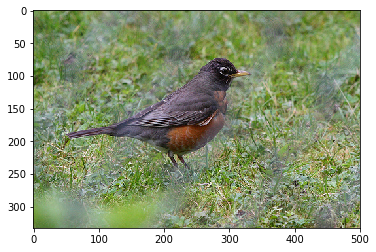

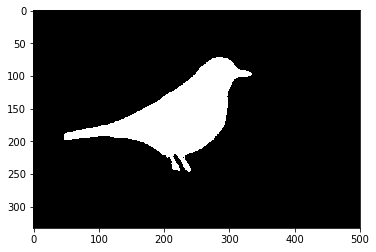

In [4]:
#随便展示一张图片及其它的label
%matplotlib inline
path = line.strip().split(" ")
img = plt.imread(path[0], 0) #不管alpha通道
label = plt.imread(path[1])
print("img shape:", img.shape)
print("label shape:", label.shape)
print("classes:", np.unique(label))
plt.imshow(img)
plt.show()
plt.imshow(label,  cmap='gray')
plt.show()

### 5.3 参数配置及训练
思路是：
* 1、模型选择：先使用本项目V1版本的my_deeplabv3.yml配置，分别尝试了backbone为Resnet50的deeplabv3、backbone为Resnet101的deeplabv3、backbone为Resnet50的deeplabv3p、backbone为Resnet50的deeplabv3p，同时使用ocrnet的官方配置（只修改了数据增强）的backbone为HRNet_W48的ocrnet模型，最后敲定了效果相对好、速度快的backbone为Resnet50的deeplabv3模型；
* 2、loss选择：最先使用了CrossEntropy，也使用了CrossEntropy和LovaszSoftmaxLoss或DiceLoss的加权混合，但发现加权混合之后效果没提升且影响训练速度，故敲定CrossEntropy
* 3、数据增强：最初是只有RandomHorizontalFlip、RandomVerticalFlip、RandomDistort和Resize(256)、Normalize，后来增加了ResizeStepScaling，Resize变为Resize（384），Normalize使用ImageNet的均值和方差
* 4、参数调值：学习率调来调去，最终使用lr为0.01的等官方配置，不过学习率衰减策略使用了PolynomialDecay、CosineWarmup分别得到模型进行集成，batch_size调大太慢，还是用了batch_size=8，不过增大了epochs
* 5、优化器的选取：试过adam，最终还是用更稳的sgd
* 6、模型集成：最终使用6~7个模型集成的结果，提高了约0.005个点
> 在my_deeplabv3_1.yml中修改参数配置，最新的参数配置如下：
```
batch_size: 8
iters: 100000
train_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  train_path: /home/aistudio/train.txt
  num_classes: 2
  transforms:
    - type: ResizeStepScaling
      min_scale_factor: 0.5
      max_scale_factor: 1.5
      scale_step_size: 0.25
    - type: RandomHorizontalFlip
    - type: RandomDistort
      brightness_range: 0.4
      contrast_range: 0.4
      saturation_range: 0.4
    - type: Resize
      target_size: [384, 384]
    - type: Normalize
      mean: [0.485, 0.456, 0.406]
      std: [0.229, 0.224, 0.225]
  mode: train
  
val_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  val_path: /home/aistudio/val.txt
  num_classes: 2
  transforms:
    - type: Resize
      target_size: [384, 384]
    - type: Normalize
      mean: [0.485, 0.456, 0.406]
      std: [0.229, 0.224, 0.225]
  mode: val

model:
  type: DeepLabV3
  num_classes: 2
  backbone:
    type: ResNet50_vd
    output_stride: 8
    multi_grid: [1, 2, 4]
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/resnet50_vd_ssld_v2.tar.gz
  backbone_indices: [3]
  aspp_ratios: [1, 12, 24, 36]
  aspp_out_channels: 256
  align_corners: False
  pretrained: output_deeplabv3_10/iter_100000/model.pdparams

optimizer:
  type: sgd
  momentum: 0.9
  weight_decay: 1.0-4

lr_scheduler:
  type: PolynomialDecay
  learning_rate: 0.01 
  end_lr: 0
  power: 0.9
  
loss:
  types:
    - type: MixedLoss
      losses:
        - type: CrossEntropyLoss
        #- type: LovaszSoftmaxLoss
        #- type: DiceLoss
      coef: [1.0]
  coef: [1]
```
，重启后直接运行下一行代码训练及验证

In [ ]:
!python PaddleSeg/train.py --config my_deeplabv3_1.yml --do_eval --use_vdl --save_dir /home/aistudio/output_deeplabv3_9 --save_interval 2000 --log_iters 20

> 中间断过几次（校园网不稳定），每次都从断点resume恢复了训练，不过断点的模型也留了下来，效果差不多的（评测超过0.76的就用于模型继承了），最后最好的结果是至此以上结果的集成

> 最后还在上面配置得到的模型基础上继续了40000次迭代（因为看visualdl eval miou曲线还在缓慢上升），不过使用了以下配置，多用了一种数据增强、使用了温启余弦衰减（在config.py增加的调用），减小学习率、增大权重衰减系数，（这个·训完没来得及集成）
```
batch_size: 8
iters: 40000
train_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  train_path: /home/aistudio/train.txt
  num_classes: 2
  transforms:
    - type: ResizeStepScaling
      min_scale_factor: 0.5
      max_scale_factor: 1.5
      scale_step_size: 0.25
    - type: RandomHorizontalFlip
    - type: RandomVerticalFlip 
    - type: RandomDistort
      brightness_range: 0.4
      contrast_range: 0.4
      saturation_range: 0.4
    - type: Resize
      target_size: [384, 384]
    - type: Normalize
      mean: [0.485, 0.456, 0.406]
      std: [0.229, 0.224, 0.225]
  mode: train

val_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  val_path: /home/aistudio/val.txt
  num_classes: 2
  transforms:
    - type: Resize
      target_size: [384, 384]
    - type: Normalize
      mean: [0.485, 0.456, 0.406]
      std: [0.229, 0.224, 0.225]
  mode: val

model:
  type: DeepLabV3
  num_classes: 2
  backbone:
    type: ResNet50_vd
    output_stride: 8
    multi_grid: [1, 2, 4]
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/resnet50_vd_ssld_v2.tar.gz
  backbone_indices: [3]
  aspp_ratios: [1, 12, 24, 36]
  aspp_out_channels: 256
  align_corners: False
  pretrained: output_deeplabv3_10/iter_100000/model.pdparams

optimizer:
  type: sgd
  momentum: 0.9
  weight_decay: 1.0e-3

lr_scheduler:
  type: CosineWarmup
  learning_rate: 0.001 
  start_lr: 0.
  eta_min: 0.

loss:
  types:
    - type: MixedLoss
      losses:
        - type: CrossEntropyLoss
      coef: [1.0]
  coef: [1]
```
重启后直接运行下一行代码训练及验证，这个最终的方案最高为0.76686，不不过还是不如集成

In [ ]:
!python PaddleSeg/train.py --config my_deeplabv3_1.yml --do_eval --use_vdl --save_dir /home/aistudio/output_deeplabv3_11 --save_interval 2000 --log_iters 20

### 5.4 推理
已在PaddleSeg中做了修改可以直接预测出结果
> 尝试了TTA，比如 flip_horizontal flip_vertical scales 1.0 0.75 1.25 ，不过会比较慢

In [ ]:
#推理
!python PaddleSeg/predict.py --config my_deeplabv3_1.yml --model_path output_deeplabv3_12/best_model/model.pdparams --image_path data/test_image --save_dir output_b/result_6 --aug_pred --flip_horizontal --scales 1.0 0.75 1.25 --flip_vertical

### 5.5 集成
将B榜时多个断点模型、A榜时的最好模型的预测结果进行逐图像逐像素投票表决得到最终的集成结果，所有可能涉及的checkpoint在这个网盘链接里链接：https://pan.baidu.com/s/1yqxndY9_k_j7UIn76jnCDQ 提取码：zpc6 

In [11]:
from collections import Counter

if not os.path.exists('results_new'):
    os.mkdir('results_new')
dir_list = os.listdir('output_b')
path_list = [os.path.join('output_b', d, 'results') for d in dir_list]
img_list = os.listdir(path_list[0])
for img_path in tqdm(img_list):
    imgs = [np.array(Image.open(os.path.join(path, img_path))) for path in path_list] #0, 255
    h, w = imgs[0].shape
    new_img = np.zeros_like(imgs[0])
    for i in range(h):
        for j in range(w):
            values = [img[i, j] for img in imgs]
            most_v = Counter(values).most_common(1)[0][0]
            new_img[i, j] = most_v
    new_img = Image.fromarray(new_img)
    new_img.save(os.path.join('results_new', img_path))

### 5.6 压缩结果，提交文件
[第三届中国AI+创新创业大赛：半监督学习目标定位竞赛](https://aistudio.baidu.com/aistudio/competition/detail/78)

In [12]:
#%cd output_b/result_6/results
!zip -r -oq /home/aistudio/pred.zip ./results_new
%cd /home/aistudio

/home/aistudio


### 5.6 补充PaddleSeg的修改部分
（可能不全）
* 学习率衰减修改：
```
if lr_type =='CosineWarmup':
  params.setdefault('eta_min', 0)
  lr = params.pop('learning_rate')
  params.setdefault('start_lr', 0)
  params.setdefault('end_lr', lr)
  lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=lr, T_max=int(0.95*self.iters), eta_min=params.pop('eta_min'))
  return paddle.optimizer.lr.LinearWarmup(learning_rate=lr, warmup_steps=int(0.05*self.iters), **params)
```
* dataset.py修改（eval时0，255改为0,1）：
```
label = label[:, :, 0]
if max(np.unique(label))>1:
  label = label/255.
label = label.astype("int64")
```
* transform.py修改（train时0，255改为0,1）：
```
label = label[:, :, 0]
if max(np.unique(label))>1:
	label = label/255.
label = label.astype("int64")
```
* predict.py修改：
```
#save 单通道label图像
results_saved_dir = os.path.join(save_dir, 'results')
results_image_path = os.path.join(results_saved_dir, im_file.rsplit(".")[0] + ".jpg")
mkdir(results_image_path)
pred = pred.astype("float32")*255
pred = pred.astype("uint8")
cv2.imwrite(results_image_path, pred)
```

# 改进方向
* 试试cvpr2021等会议最新的图像分割模型架构，或进一步自己改进
* 试试cvpr2021等会议最新的半监督图像分割方案
等等